# Implementing a GPT model from Scratch To Generate Text

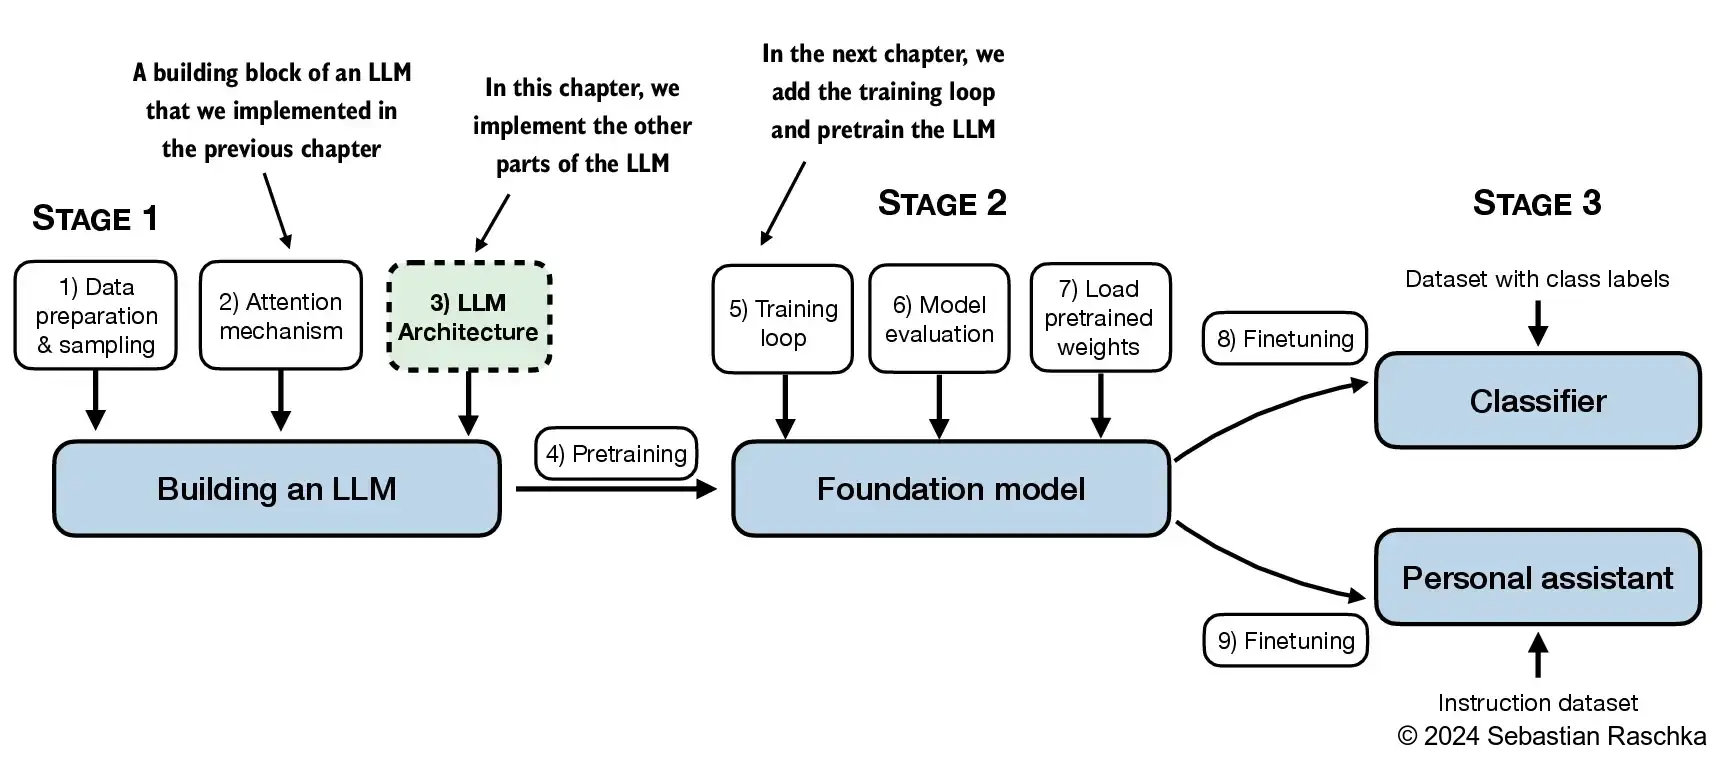

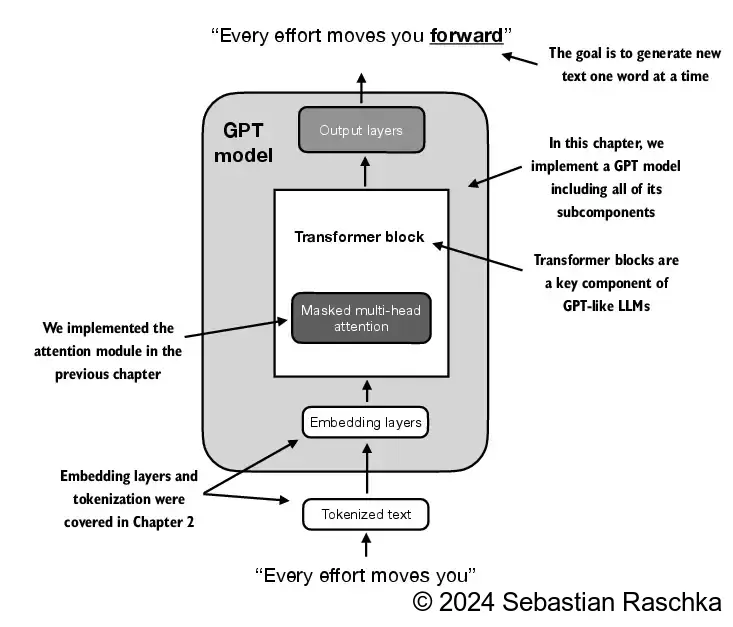

**Defines a dictionary GPT_CONFIG_124M with settings for the smallest GPT-2 model:**

- We use short variable names to avoid long lines of code later
- `"vocab_size"` indicates a vocabulary size of 50,257 words, supported by the BPE tokenizer discussed in first notebook
- `"context_length"` represents the model's maximum input token count, as enabled by positional embeddings covered in 1st notebook
- `"emb_dim"` is the embedding size for token inputs, converting each input token into a 768-dimensional vector
- `"n_heads"` is the number of attention heads in the multi-head attention mechanism implemented in 2nd notebook
- `"n_layers"` is the number of transformer blocks within the model, which we'll implement in upcoming sections
- `"drop_rate"` is the dropout mechanism's intensity, discussed in Chapter 3; 0.1 means dropping 10% of hidden units during training to mitigate overfitting
- `"qkv_bias"` decides if the `Linear` layers in the multi-head attention mechanism (from Chapter 3) should include a bias vector when computing query (Q), key (K), and value (V) tensors; we'll disable this option, which is standard practice in modern LLMs; however, we'll revisit this later when loading pretrained GPT-2 weights from OpenAI into our reimplementation in chapter 5

**This is a skeleton GPT model to illustrate the architecture. The transformer block and layer normalization are placeholders to be replaced with real implementations later.**

In [1]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

In [2]:
import torch
import torch.nn as nn

class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # A simple placeholder

    def forward(self, x):
        # This block does nothing and just returns its input.
        return x


class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        # The parameters here are just to mimic the LayerNorm interface.

    def forward(self, x):
        # This layer does nothing and just returns its input.
        return x

In [3]:
class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        # Use a placeholder for TransformerBlock
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        # Use a placeholder for LayerNorm
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [4]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

batch = []

txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [5]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)

logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)


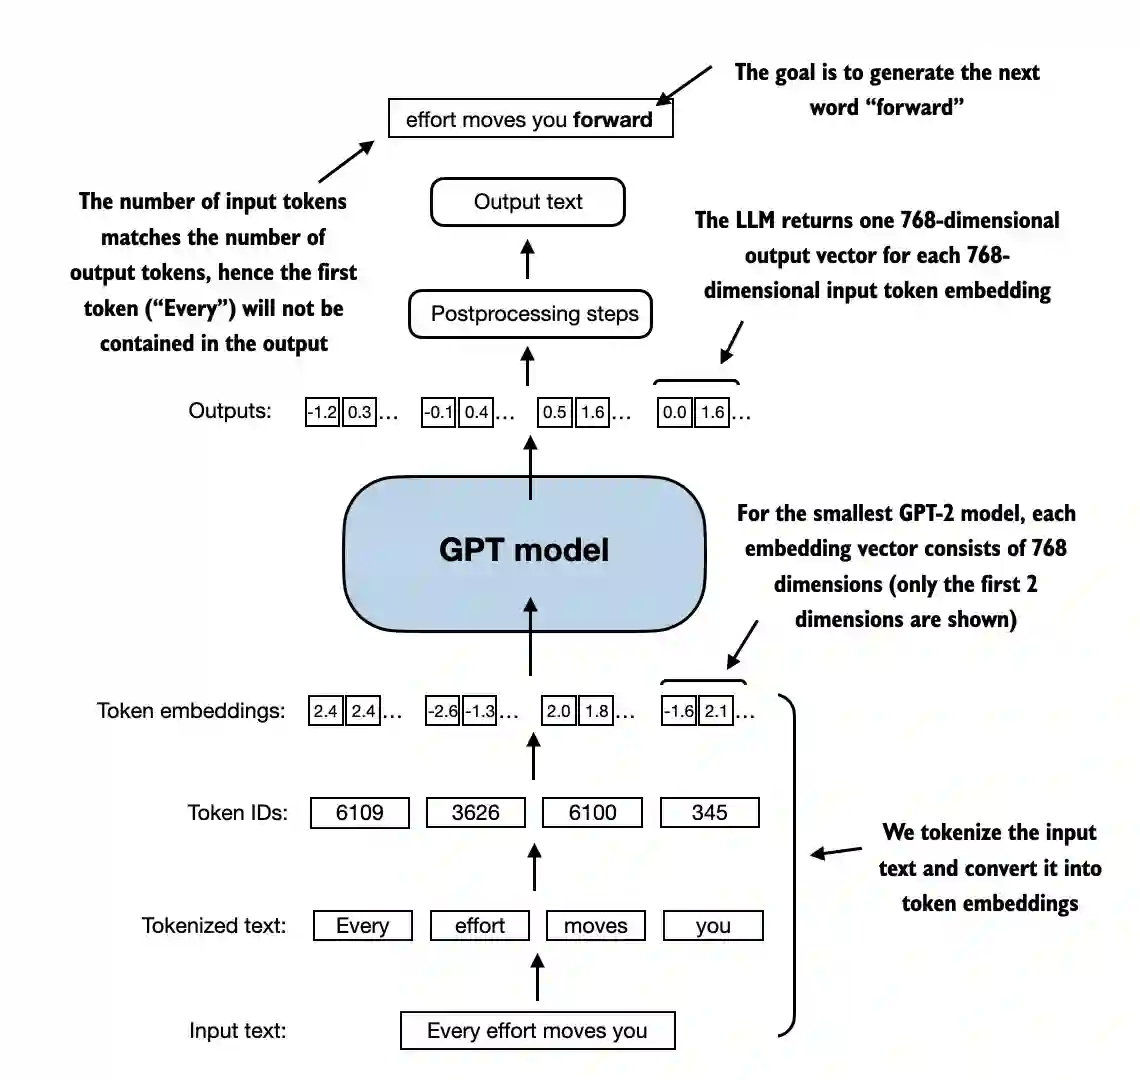

**Normalizing activations with layer normalization**

*  Layer normalization, also known as LayerNorm (Ba et al. 2016), centers the activations of a neural network layer around a mean of 0 and normalizes their variance to 1
*  This stabilizes training and enables faster convergence to effective weights
*  Layer normalization is applied both before and after the multi-head attention module within the transformer block, which we will implement later;
it's also applied before the final output layer

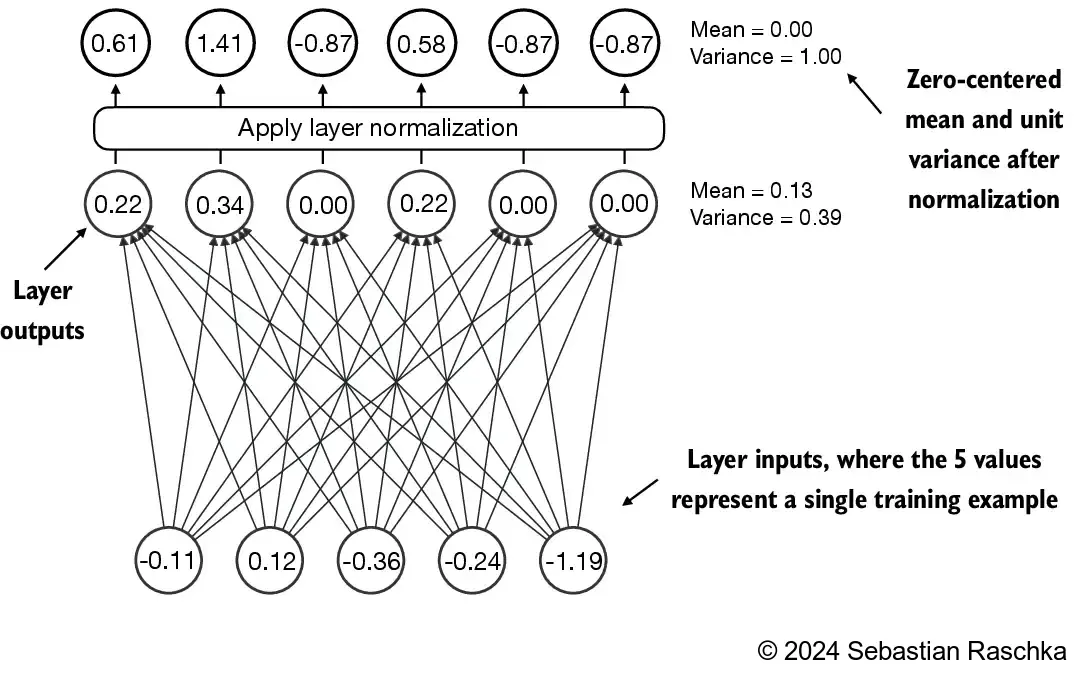

Let's see how layer normalization works by passing a small input sample through a simple neural network layer:

In [6]:
torch.manual_seed(123)

# create 2 training examples with 5 dimensions (features) each
batch_example = torch.randn(2, 5)

layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


Let's compute the mean and variance for each of the 2 inputs above:

In [7]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


The normalization is applied to each of the two inputs (rows) independently; using dim=-1 applies the calculation across the last dimension (in this case, the feature dimension) instead of the row dimension


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/06.webp" width="400px">

Subtracting the mean and dividing by the square-root of the variance (standard deviation) centers the inputs to have a mean of 0 and a variance of 1 across the column (feature) dimension:

In [8]:
out_norm = (out - mean) / torch.sqrt(var)
print("Normalized layer outputs:\n", out_norm)

mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[9.9341e-09],
        [1.9868e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


Each input is centered at 0 and has a unit variance of 1; to improve readability, we can disable PyTorch's scientific notation:


In [9]:
torch.set_printoptions(sci_mode=False)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


Above, we normalized the features of each input
Now, using the same idea, we can implement a LayerNorm class:

In [10]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

**Scale and shift**
- Note that in addition to performing the normalization by subtracting the mean and dividing by the variance, we added two trainable parameters, a `scale` and a `shift` parameter
- The initial `scale` (multiplying by 1) and `shift` (adding 0) values don't have any effect; however, `scale` and `shift` are trainable parameters that the LLM automatically adjusts during training if it is determined that doing so would improve the model's performance on its training task
- This allows the model to learn appropriate scaling and shifting that best suit the data it is processing
- Note that we also add a smaller value (`eps`) before computing the square root of the variance; this is to avoid division-by-zero errors if the variance is 0

**Biased variance**
- In the variance calculation above, setting `unbiased=False` means using the formula $\frac{\sum_i (x_i - \bar{x})^2}{n}$ to compute the variance where n is the sample size (here, the number of features or columns); this formula does not include Bessel's correction (which uses `n-1` in the denominator), thus providing a biased estimate of the variance
- For LLMs, where the embedding dimension `n` is very large, the difference between using n and `n-1` is negligible
- However, GPT-2 was trained with a biased variance in the normalization layers, which is why we also adopted this setting for compatibility reasons with the pretrained weights that we will load in later chapters

In [11]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)

In [12]:
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/07.webp" width="400px">

**Implementing a feed forward network with GELU activations**

- In this section, we implement a small neural network submodule that is used as part of the transformer block in LLMs
- We start with the activation function
- In deep learning, ReLU (Rectified Linear Unit) activation functions are commonly used due to their simplicity and effectiveness in various neural network architectures
- In LLMs, various other types of activation functions are used beyond the traditional ReLU; two notable examples are GELU (Gaussian Error Linear Unit) and SwiGLU (Swish-Gated Linear Unit)
- GELU and SwiGLU are more complex, smooth activation functions incorporating Gaussian and sigmoid-gated linear units, respectively, offering better performance for deep learning models, unlike the simpler, piecewise linear function of ReLU

- GELU ([Hendrycks and Gimpel 2016](https://arxiv.org/abs/1606.08415)) can be implemented in several ways; the exact version is defined as GELU(x)=xΦ(x), where Φ(x) is the cumulative distribution function of the standard Gaussian distribution.
- In practice, it's common to implement a computationally cheaper approximation: $\text{GELU}(x) \approx 0.5 \cdot x \cdot \left(1 + \tanh\left[\sqrt{\frac{2}{\pi}} \cdot \left(x + 0.044715 \cdot x^3\right)\right]\right)$
- (the original GPT-2 model was also trained with this approximation)

GELU (Gaussian Error Linear Unit) is defined precisely as `x * Φ(x)`, where `Φ(x)` is the Gaussian CDF.
The approximation used here (matching GPT-2) is computationally simpler: `0.5 * x * (1 + tanh(sqrt(2/π) * (x + 0.044715 * x^3)))`



In [13]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

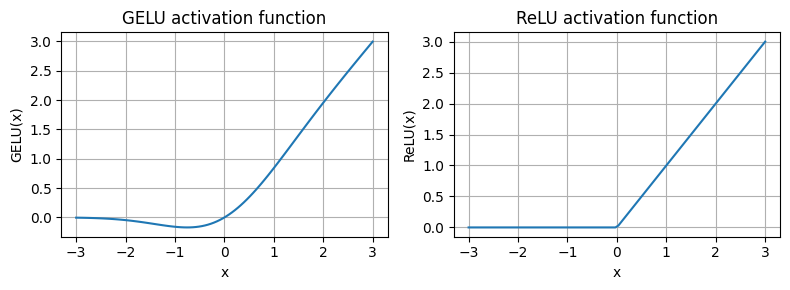

In [14]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

# Some sample data
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

*  As we can see, ReLU is a piecewise linear function that outputs the input directly if it is positive; otherwise, it outputs zero

*  GELU is a smooth, non-linear function that approximates ReLU but with a non-zero gradient for negative values (except at approximately -0.75)

*  Next, let's implement the small neural network module, FeedForward, that we will be using in the LLM's transformer block later:

In [15]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

In [16]:
print(GPT_CONFIG_124M["emb_dim"])

768


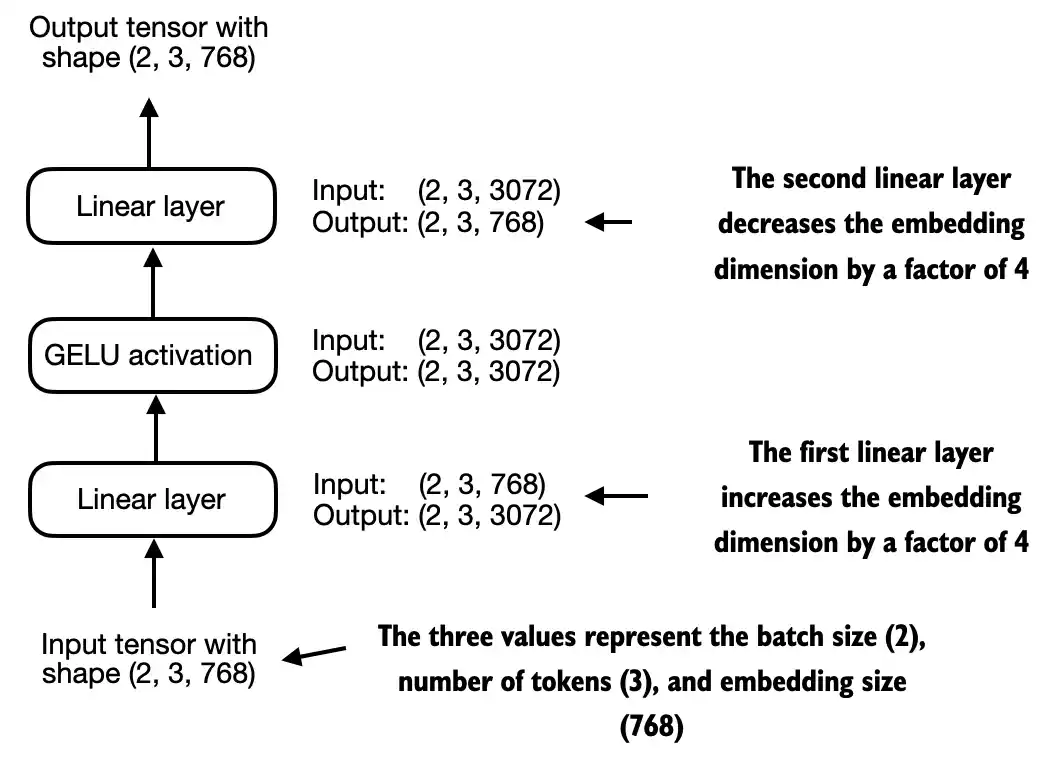

In [17]:
ffn = FeedForward(GPT_CONFIG_124M)

# input shape: [batch_size, num_token, emb_size]
x = torch.rand(2, 3, 768)
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


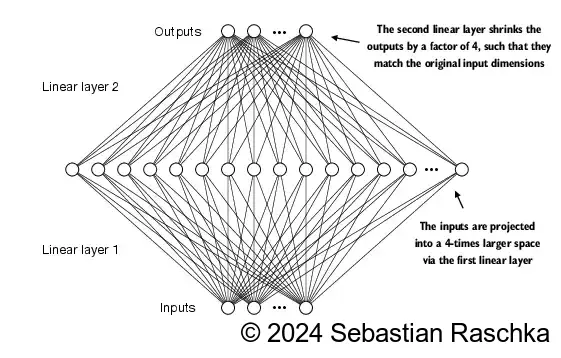

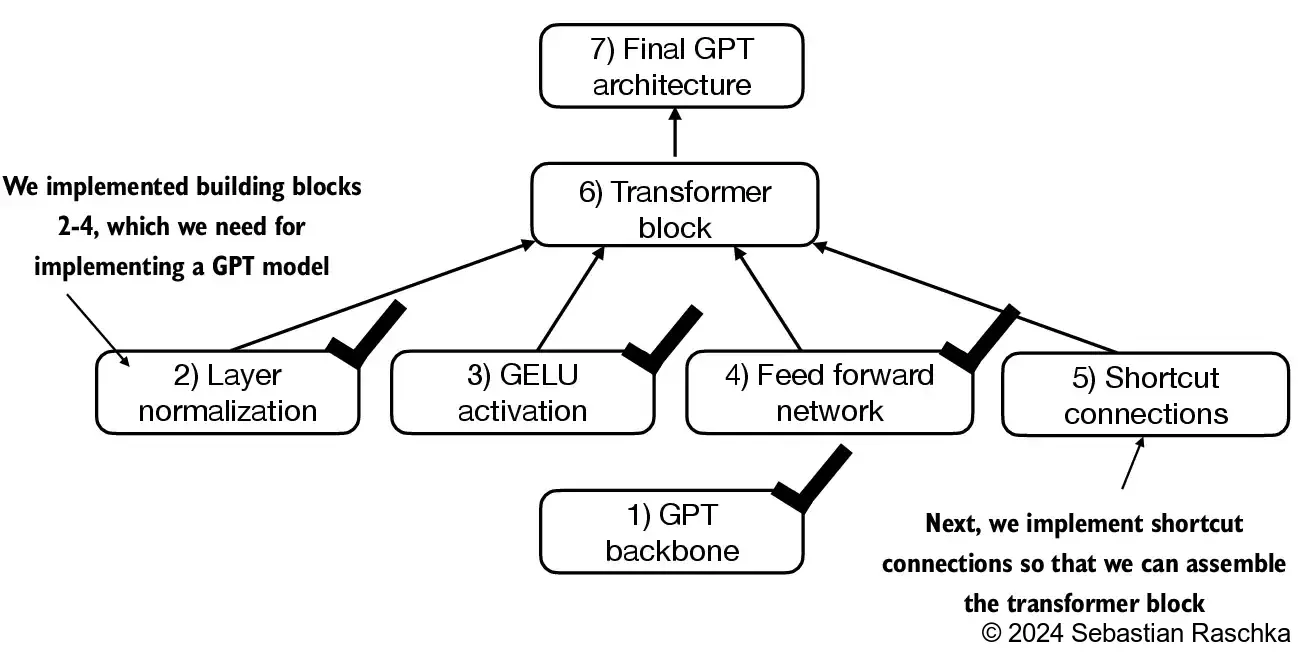

# Adding shortcut connections

* Next, let's talk about the concept behind shortcut connections, also called skip or residual connections
* Originally, shortcut connections were proposed in deep networks for computer vision (residual networks) to mitigate vanishing gradient problems
* A shortcut connection creates an alternative shorter path for the gradient to flow through the network
* This is achieved by adding the output of one layer to the output of a later layer, usually skipping one or more layers in between

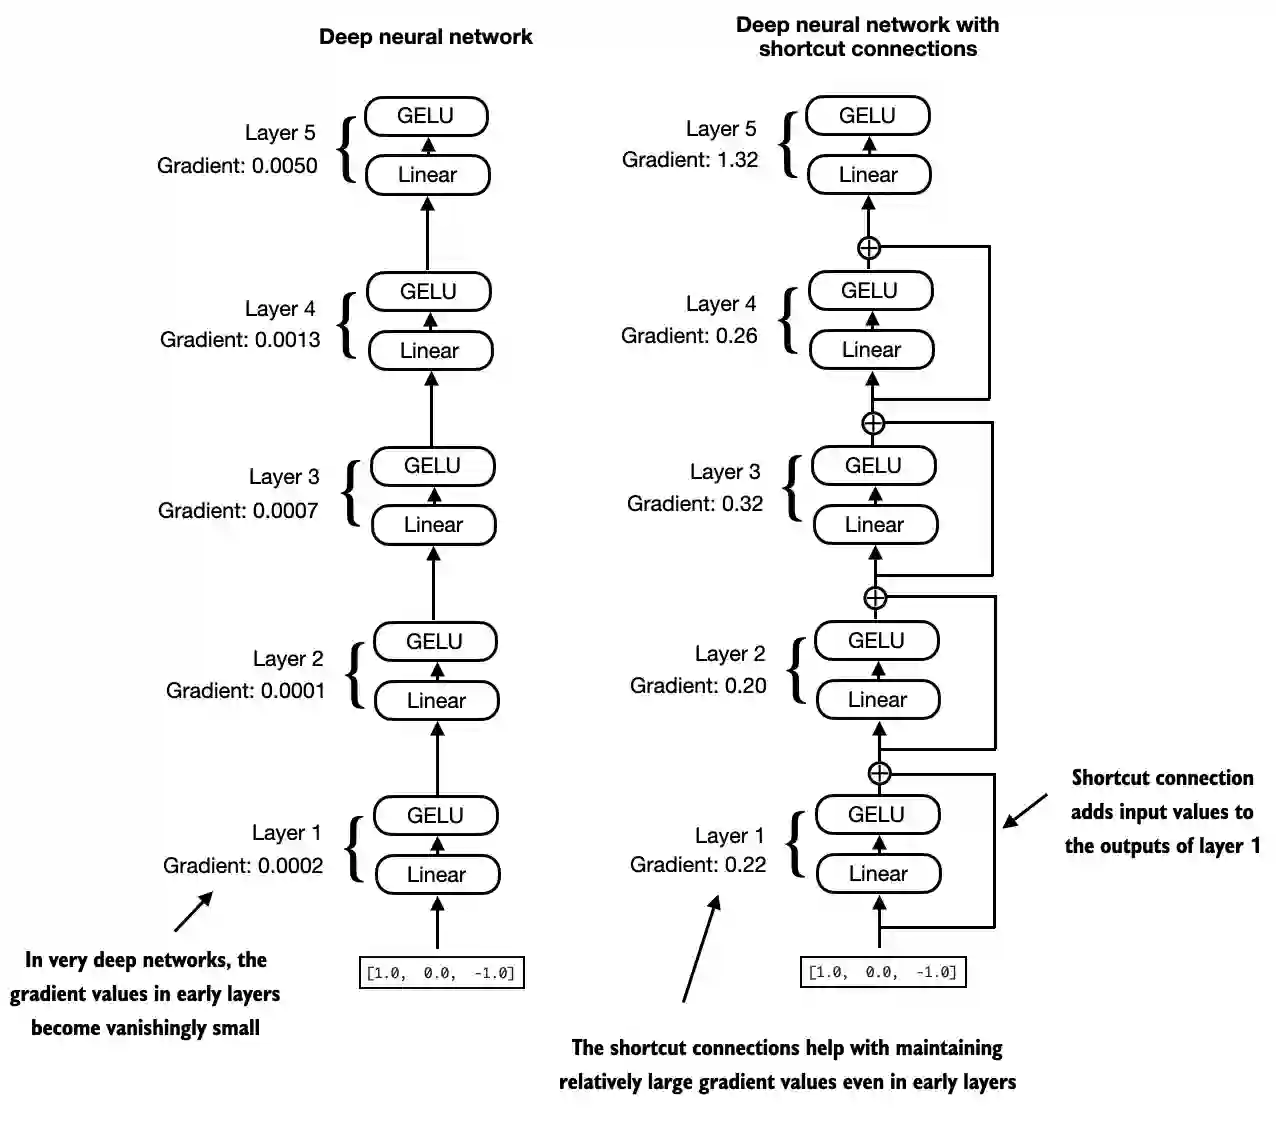

In [18]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            # Compute the output of the current layer
            layer_output = layer(x)
            # Check if shortcut can be applied
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x


def print_gradients(model, x):
    # Forward pass
    output = model(x)
    target = torch.tensor([[0.]])

    # Calculate loss based on how close the target
    # and output are
    loss = nn.MSELoss()
    loss = loss(output, target)

    # Backward pass to calculate the gradients
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            # Print the mean absolute gradient of the weights
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

Let's print the gradient values first without shortcut connections

let's print the gradient values without shortcut connections:

In [19]:
layer_sizes = [3, 3, 3, 3, 3, 1]

sample_input = torch.tensor([[1., 0., -1.]])

torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173584925942123
layers.1.0.weight has gradient mean of 0.00012011159560643137
layers.2.0.weight has gradient mean of 0.0007152040489017963
layers.3.0.weight has gradient mean of 0.0013988736318424344
layers.4.0.weight has gradient mean of 0.005049645435065031


Next, let's print the gradient values with shortcut connections:

In [20]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169791162014008
layers.1.0.weight has gradient mean of 0.20694105327129364
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576


* As we can see based on the output above, shortcut connections prevent the gradients from vanishing in the early layers (towards layer.0)
* We will use this concept of a shortcut connection next when we implement a transformer block

## Connecting attention and linear layers in a transformer block

In [22]:
from previous_chapters import MultiHeadAttention
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x

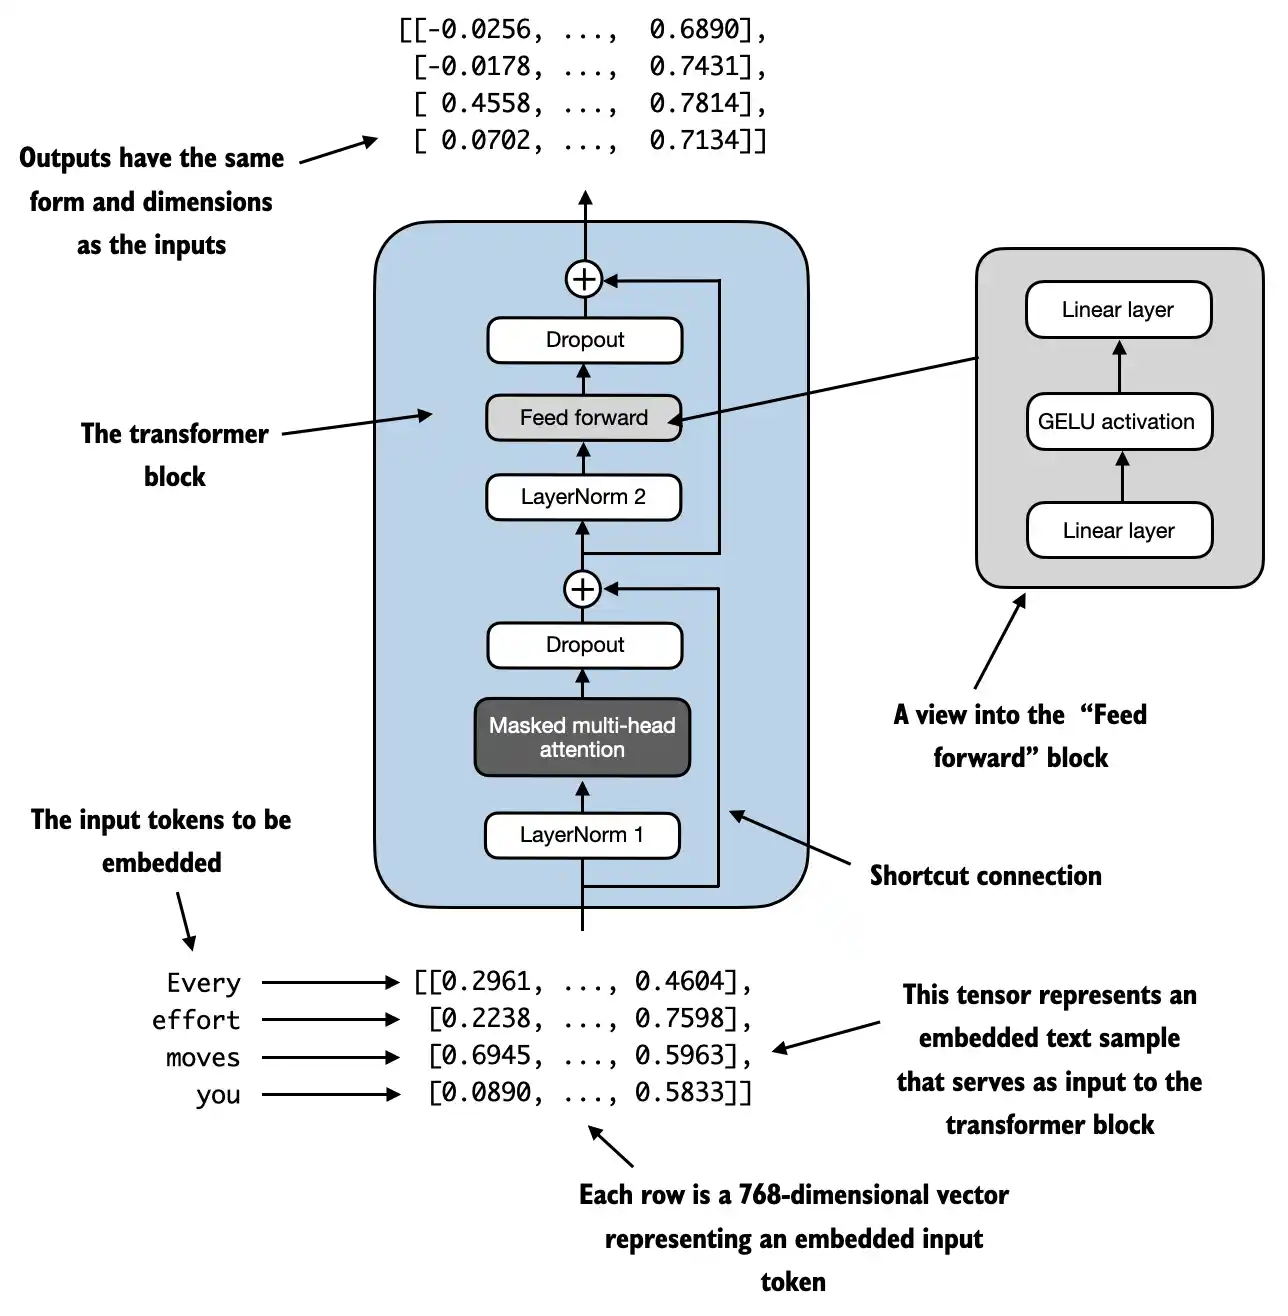

Suppose we have 2 input samples with 6 tokens each, where each token is a 768-dimensional embedding vector; then this transformer block applies self-attention, followed by linear layers, to produce an output of similar size

In [23]:
torch.manual_seed(123)

x = torch.rand(2, 4, 768)  # Shape: [batch_size, num_tokens, emb_dim]
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


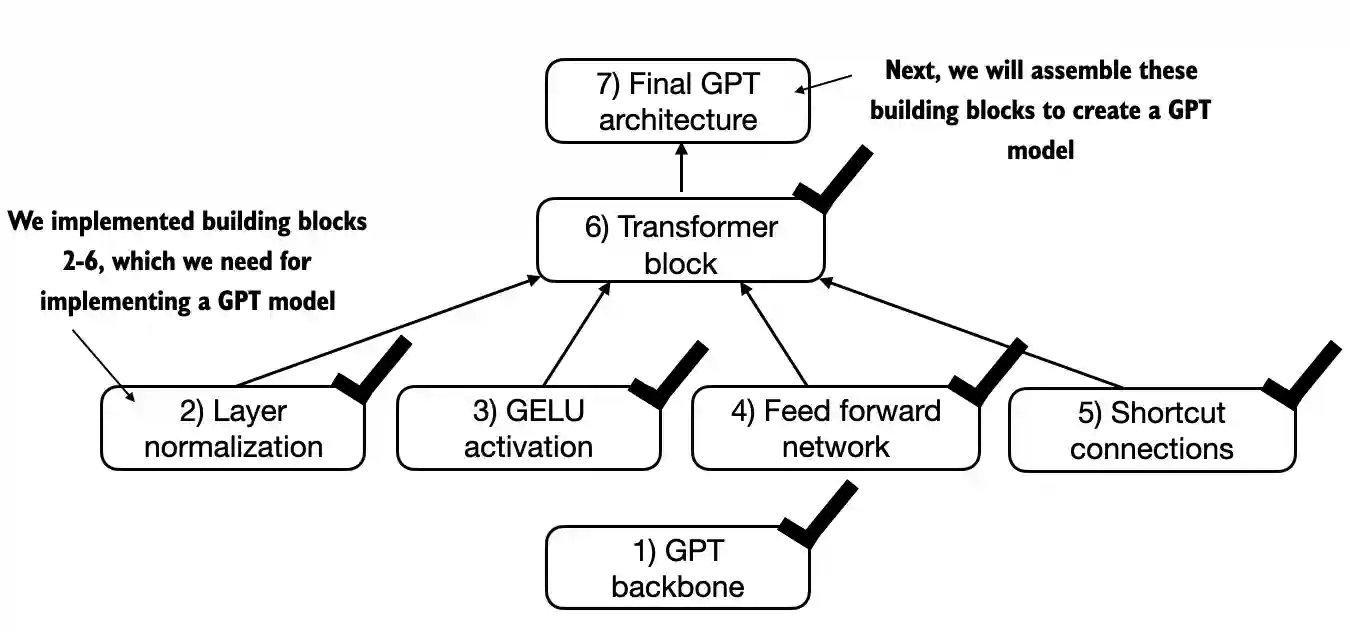

# Coding The GPT model

We are almost there: now let's plug in the transformer block into the architecture we coded at the very beginning of this chapter so that we obtain a usable GPT architecture
Note that the transformer block is repeated multiple times; in the case of the smallest 124M GPT-2 model, we repeat it 12 times:

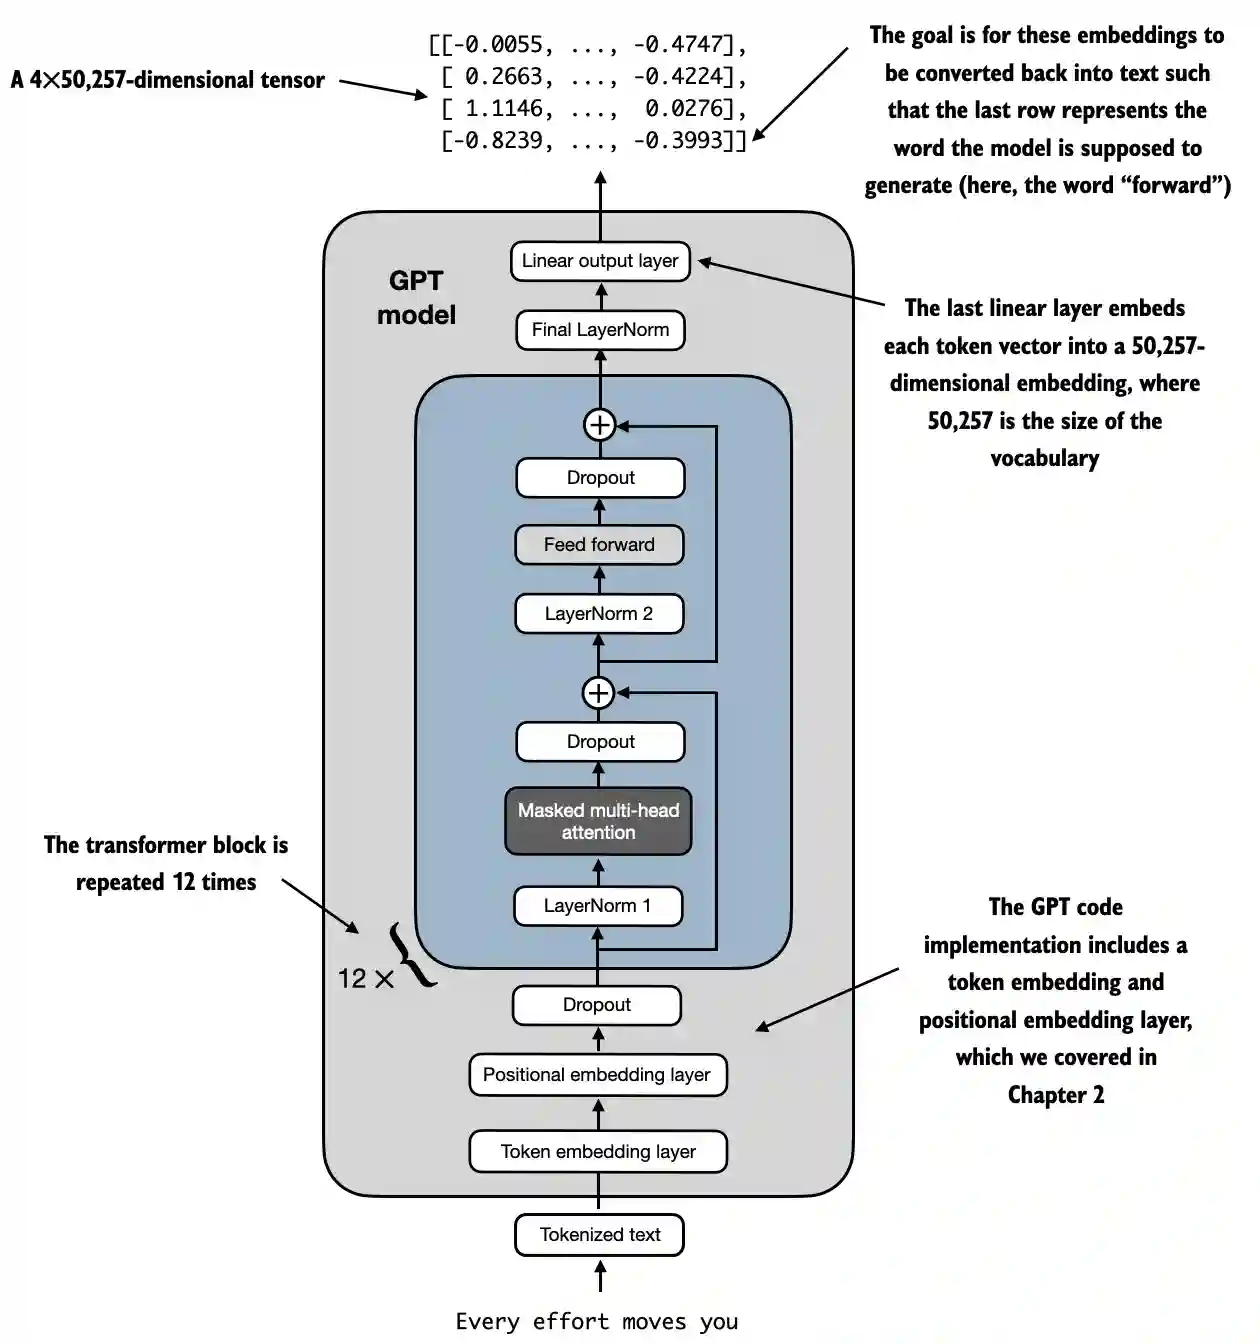

The corresponding code implementation, where `cfg["n_layers"] = 12:`

In [24]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

Using the configuration of the 124M parameter model, we can now instantiate this GPT model with random initial weights as follows:

In [25]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.1381,  0.0077, -0.1963,  ..., -0.0222, -0.1060,  0.1717],
         [ 0.3865, -0.8408, -0.6564,  ..., -0.5163,  0.2369, -0.3357],
         [ 0.6989, -0.1829, -0.1631,  ...,  0.1472, -0.6504, -0.0056],
         [-0.4290,  0.1669, -0.1258,  ...,  1.1579,  0.5303, -0.5549]],

        [[ 0.1094, -0.2894, -0.1467,  ..., -0.0557,  0.2911, -0.2824],
         [ 0.0882, -0.3552, -0.3527,  ...,  1.2930,  0.0053,  0.1898],
         [ 0.6091,  0.4702, -0.4094,  ...,  0.7688,  0.3787, -0.1974],
         [-0.0612, -0.0737,  0.4751,  ...,  1.2463, -0.3834,  0.0609]]],
       grad_fn=<UnsafeViewBackward0>)


A quick note about its size: we previously referred to it as a 124M parameter model; we can double check this number as follows:

In [29]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


*  As we see above, this model has 163M, not 124M parameters; why?
*  In the original GPT-2 paper, the researchers applied weight tying, which means that they reused the token embedding layer (tok_emb) as the output layer, which means setting self.`out_head.weight = self.tok_emb.weight`
*  The token embedding layer projects the 50,257-dimensional one-hot encoded input tokens to a 768-dimensional embedding representation
*  The output layer projects 768-dimensional embeddings back into a 50,257-dimensional representation so that we can convert these back into words (more about that in the next section)
*  So, the embedding and output layer have the same number of weight parameters, as we can see based on the shape of their weight matrices
*  However, a quick note about its size: we previously referred to it as a 124M parameter model; we can double check this number as follows:

In [30]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


In the original GPT-2 paper, the researchers reused the token embedding matrix as an output matrix
Correspondingly, if we subtracted the number of parameters of the output layer, we'd get a 124M parameter model:

In [32]:
total_params_gpt2 =  total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

Number of trainable parameters considering weight tying: 124,412,160


* In practice, I found it easier to train the model without weight-tying, which is why we didn't implement it here
* However, we will revisit and apply this weight-tying idea later when we load the pretrained weights in chapter 5
* Lastly, we can compute the memory requirements of the model as follows, which can be a helpful reference point:

In [33]:
# Calculate the total size in bytes (assuming float32, 4 bytes per parameter)
total_size_bytes = total_params * 4

# Convert to megabytes
total_size_mb = total_size_bytes / (1024 * 1024)

print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


### Exercise

You can try the following other configurations, which are referenced in the GPT-2 paper, as well.

#### GPT2-small *(124M, already implemented)*:
- `emb_dim = 768`
- `n_layers = 12`
- `n_heads = 12`

#### GPT2-medium:
- `emb_dim = 1024`
- `n_layers = 24`
- `n_heads = 16`

#### GPT2-large:
- `emb_dim = 1280`
- `n_layers = 36`
- `n_heads = 20`

#### GPT2-XL:
- `emb_dim = 1600`
- `n_layers = 48`
- `n_heads = 25`


**Generating text**

* LLMs like the GPT model we implemented above are used to generate one word at a time

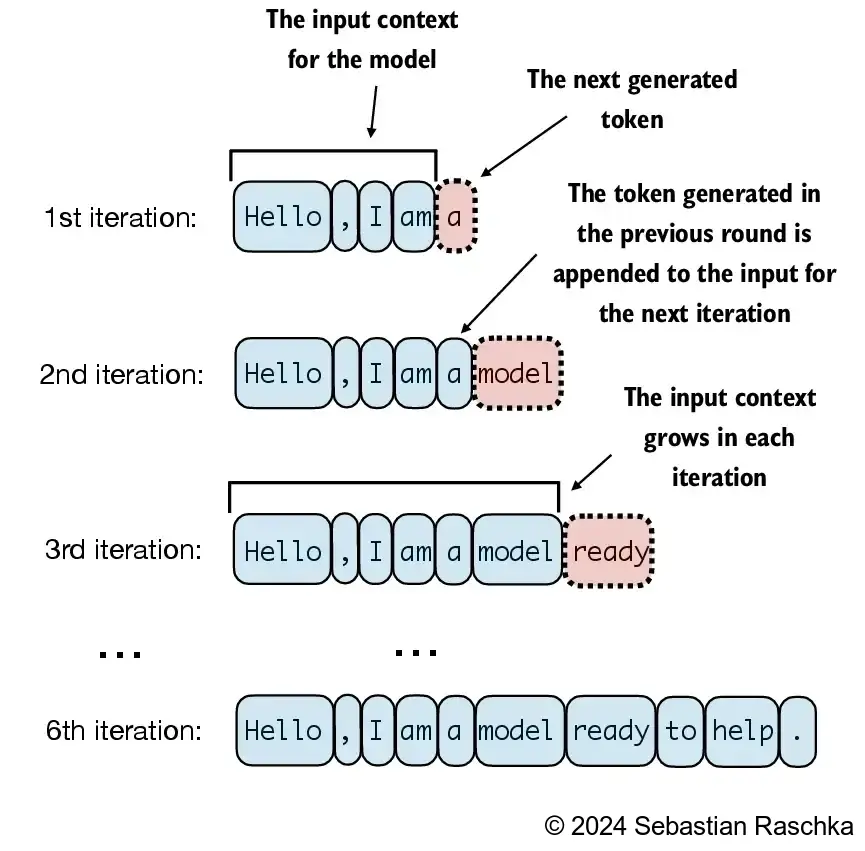

The following `generate_text_simple` function implements greedy decoding, which is a simple and fast method to generate text
In greedy decoding, at each step, the model chooses the word (or token) with the highest probability as its next output (the highest logit corresponds to the highest probability, so we technically wouldn't even have to compute the softmax function explicitly)
In the next chapter, we will implement a more advanced `generate_text` function
The figure below depicts how the GPT model, given an input context, generates the next word token

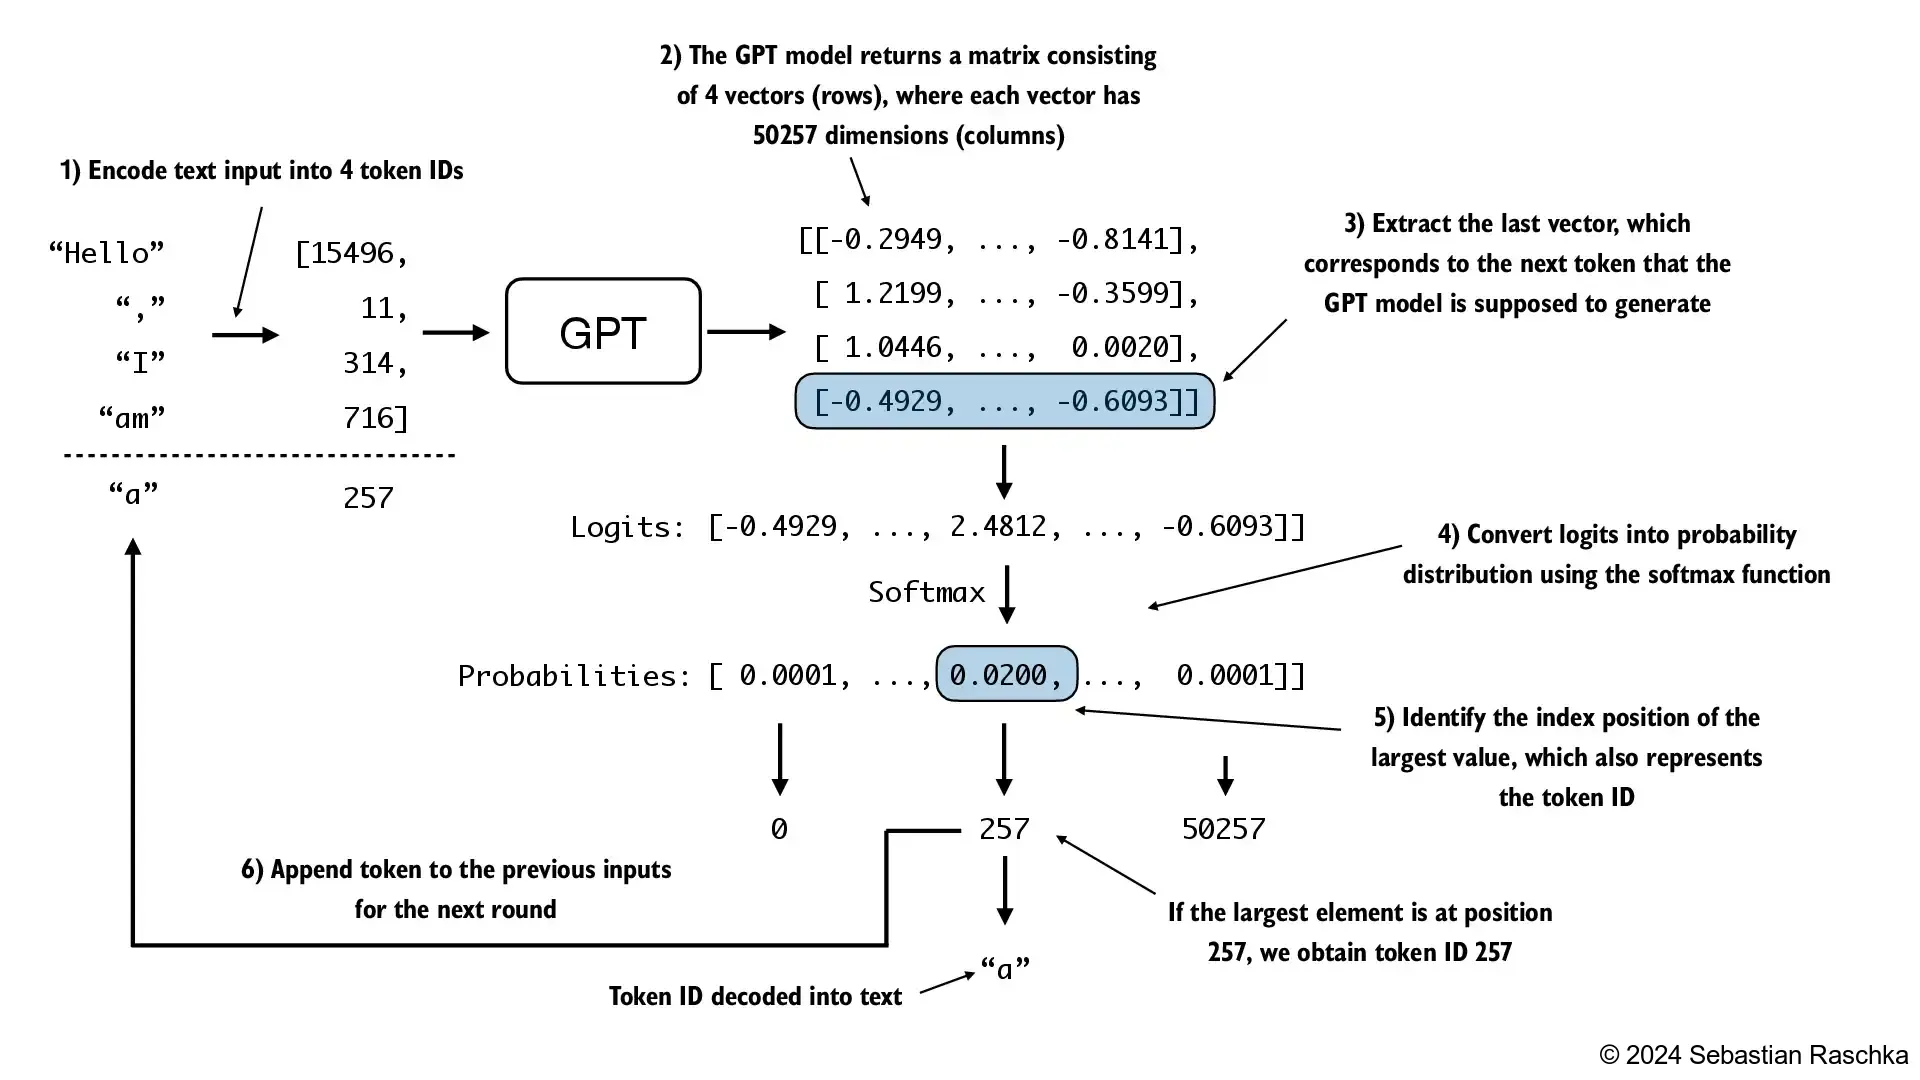

In [34]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context
    for _ in range(max_new_tokens):

        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)

        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

*  The `generate_text_simple` above implements an iterative process, where it creates one token at a time

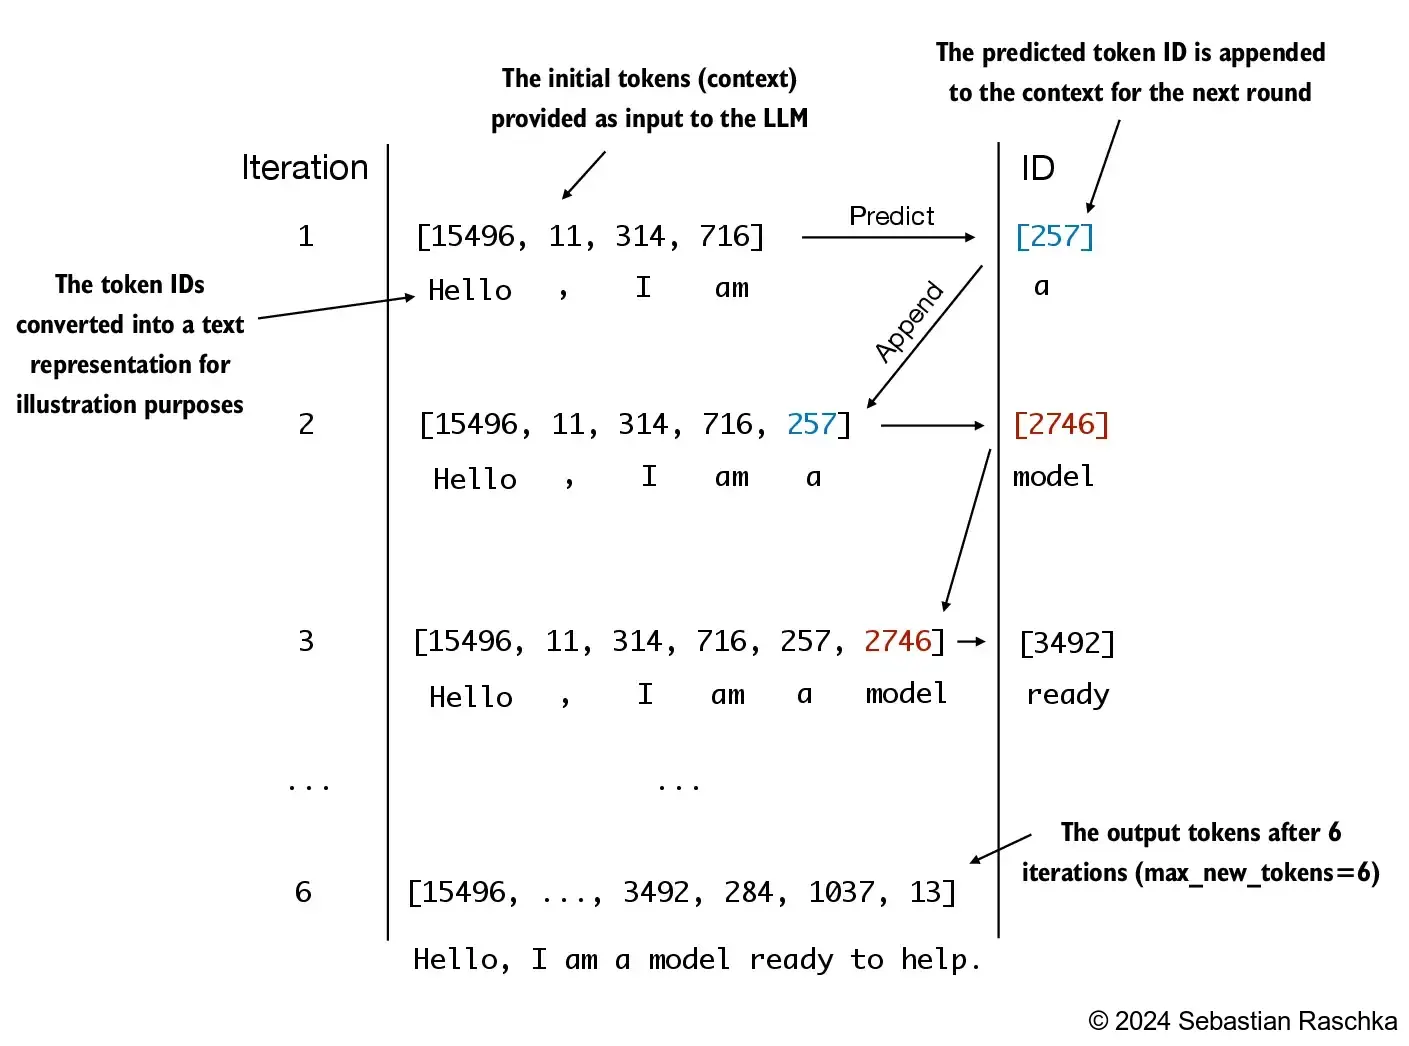

## Input Example

In [35]:
start_context = "Hello, I am"

encoded = tokenizer.encode(start_context)
print("encoded:", encoded)

encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [36]:
model.eval() # disable dropout

out = generate_text_simple(
    model=model,
    idx=encoded_tensor,
    max_new_tokens=6,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10


In [37]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Featureiman Byeswickattribute argue


* Note that the model is untrained; hence the random output texts above
* We will train the model in the next chapter